In [1]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
# Import metrics from scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set random seed and device
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Define data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
cifar10_full = torchvision.datasets.CIFAR10(root='./datasets', train=True, download=False, transform=transform_train)
train_size = int(0.9 * len(cifar10_full))
val_size = len(cifar10_full) - train_size
cifar10_train, cifar10_val = random_split(cifar10_full, [train_size, val_size])

cifar10_test = torchvision.datasets.CIFAR10(root='./datasets', train=False, download=False, transform=transform_test)

batch_size = 128
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(cifar10_val, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [3]:
# Definition of simplified AlexNet model class
class SimplifiedAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimplifiedAlexNet, self).__init__()
        self.features = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # add dropout
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16

            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # add dropout
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 -> 8x8

            # Conv Layer block 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # add dropout
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2)   # 8x8 -> 4x4
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            # add dropout
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

In [4]:
# load model
model = SimplifiedAlexNet(num_classes=10).to(device)
print(model)

SimplifiedAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    return running_loss / len(dataloader.dataset), correct / total


print("Selected AlexNet parameter count:", count_parameters(model))

Selected AlexNet parameter count: 620362


In [ ]:
num_epochs = 30
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

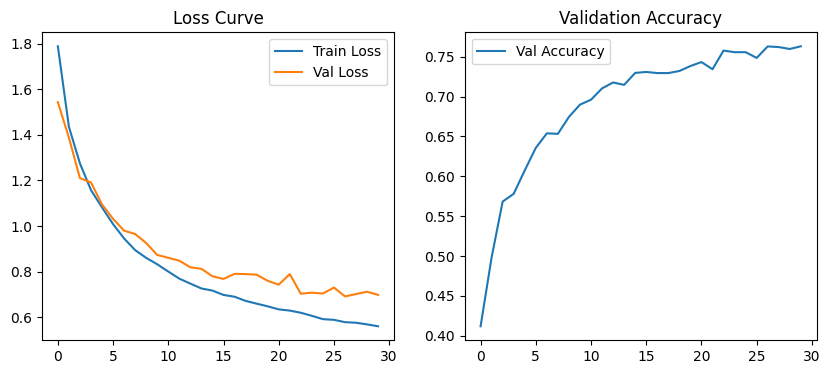

In [7]:
# Save training data and plot the curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Validation Accuracy")
plt.savefig("./images/p1_10_simplified_alexnet_results.png")
# plt.savefig("./images/p1_10_simplified_original_alexnet_results.png")
plt.show()

In [8]:
def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)

In [9]:
# Compute predictions on the test set
test_preds, test_targets = compute_metrics(model, test_loader)

# Calculate precision, recall, and F1 score (weighted average)
precision = precision_score(test_targets, test_preds, average="weighted")
recall = recall_score(test_targets, test_preds, average="weighted")
f1 = f1_score(test_targets, test_preds, average="weighted")
conf_matrix = confusion_matrix(test_targets, test_preds)
class_report = classification_report(test_targets, test_preds, target_names=cifar10_test.classes)

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Test Precision: 0.7826308029374085
Test Recall: 0.7774
Test F1 Score: 0.7783382927381468

Confusion Matrix:
 [[822   8  33  20  10   7  11  11  48  30]
 [ 18 832   7  14   2   5  10   3  13  96]
 [ 60   3 640  67  58  40  87  36   3   6]
 [ 19   3  42 659  43 121  56  36   6  15]
 [ 13   1  43  70 771  27  32  39   4   0]
 [ 11   0  27 232  35 631  10  48   2   4]
 [  2   1  22  63  25  15 862   7   2   1]
 [  9   1  10  47  33  63  12 818   2   5]
 [ 50  14  11  17   9   5   5   6 865  18]
 [ 26  35   7  18   1   4   6   9  20 874]]

Classification Report:
               precision    recall  f1-score   support

    airplane       0.80      0.82      0.81      1000
  automobile       0.93      0.83      0.88      1000
        bird       0.76      0.64      0.69      1000
         cat       0.55      0.66      0.60      1000
        deer       0.78      0.77      0.78      1000
         dog       0.69      0.63      0.66      1000
        frog       0.79      0.86      0.82      1000
  

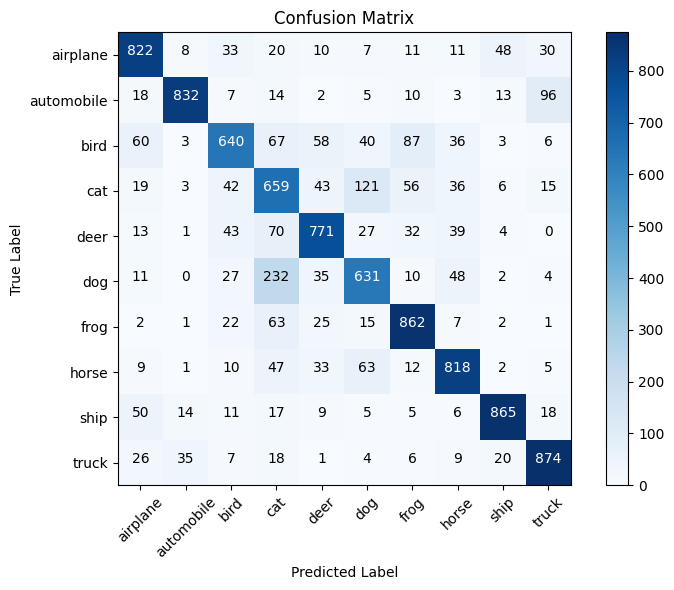

In [10]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(cifar10_test.classes))
plt.xticks(tick_marks, cifar10_test.classes, rotation=45)
plt.yticks(tick_marks, cifar10_test.classes)

# Annotate the confusion matrix cells with the numeric values
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("./images/p1_10_simplified_confusion_matrix.png")
# plt.savefig("./images/p1_10_simplified_dropout_confusion_matrix.png")
plt.show()